## TODOS
- Read the T5 paper
- Read the DETR paper
- Create this mixed model with sigmoid gating mechanism

## T5 Paper Notes

- No major variations on architecture relative to the og transformer paper. 
- Cleaned up Common Crawl's extracted text -> colossal clean crawled corpus C4 for short. Note that C4 is english-only, and that may have some limitations on emergent abilities of the model. I don't have a paper here but I'm fairly certain that there is evidence to suggest that models trained on multiple languages + even code have better reasoning capabilities. 
- Cast all objectives as text only format. Or, in other words, they append a task-specific prefix into the prompt of specific types of tasks and try to train over that. 

" To summarize, our model is roughly equivalent to the original Transformer proposed by Vaswani et al. (20-17) with the exception of removing the Layer Norm bias, placing the layer normalization outside the residual path, and using a different position embedding scheme. "




## DETR Paper Notes
- Basically just stuck a transformer to the end of a resnet. Did some ablation tests, but ntothing super interesting. 
- Seems like this hungarian algorithm for computing optimal bipartite matching is core in the algorithm, but that is also a concept borrowed from previous work. Basically jointly computes a loss and learns the class prediction + bounding box at the same time. 

In [1]:
from transformers import T5Tokenizer, T5Model, T5ForConditionalGeneration
from transformers import DetrModel, DetrImageProcessor
import torch
import inspect
from datasets import load_dataset

device = torch.device("cuda")

/home/bxliu2000/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## Language Model
lang_model_id = "t5-base"
tokenizer = T5Tokenizer.from_pretrained(lang_model_id)
lang_model = T5Model.from_pretrained(lang_model_id)

## Vision Model
vis_model_id = "facebook/detr-resnet-50"
processor = DetrImageProcessor.from_pretrained(vis_model_id)
vis_model = DetrModel.from_pretrained(vis_model_id)

/home/bxliu2000/.local/lib/python3.10/site-packages/transformers/models/t5/tokenization_t5.py:163: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
/home/bxliu2000/.local/lib/python3.10/site-packages/transformers/models/detr/image_processing_detr.py:776: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] inste

In [ ]:
# Testing shape of last activation for language model
input_ids = tokenizer(['a' * 513 for _ in range(5)], padding=True, return_tensors="pt").input_ids # (batch_size, largest_sent)
decoder_input_ids = tokenizer(["" for _ in range(5)], padding=True, return_tensors="pt").input_ids # (batch_size, largest_sent)

print(input_ids.shape, decoder_input_ids.shape)
out = lang_model(input_ids=input_ids, decoder_input_ids=decoder_input_ids)
print(out.encoder_last_hidden_state.shape)

In [3]:
# Define F(X) as in the paper 
vis_model.num_parameters() / lang_model.num_parameters() * 100

18.562374456913094

In [8]:
lang_model.config

T5Config {
  "_name_or_path": "t5-base",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
      "num_beams": 4,
      "prefix": "summarize: "
    },
    "translation_en_to_de": {
      "early_stopping": true,
      "max_length": 300,
      "num_beams": 4,
      "pre

In [5]:
dataset = load_dataset("derek-thomas/ScienceQA", split="train")

Found cached dataset parquet (/home/bxliu2000/.cache/huggingface/datasets/derek-thomas___parquet/derek-thomas--ScienceQA-ca4903a3b5795914/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


In [28]:
dataset[0:5]['image']

[<PIL.PngImagePlugin.PngImageFile image mode=RGB size=750x429>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=302x232>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=302x232>,
 None,
 None]

In [59]:
import torch.nn as nn

class MultiModal(nn.Module):
    
    def __init__(self, lang_model, vis_model, vis_processor):
        super(MultiModal, self).__init__()
        self.lang_encoder = lang_model.get_encoder()
        self.vis_model = vis_model
        self.vis_processor = vis_processor
        self.decoder = lang_model.get_decoder()
        
        self.lang_d_model = lang_model.config.d_model
        self.vis_d_model = vis_model.config.d_model
        self.num_heads = 1
        
        self.vis_head = nn.Linear(self.vis_d_model, self.lang_d_model)
        self.H_attn_vis = nn.MultiheadAttention(self.lang_d_model, self.num_heads)
        self.H_vis_attn = nn.MultiheadAttention(self.lang_d_model, self.num_heads)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, X_lang, decoder_input_ids, X_vis):
        enc_toks = self.lang_encoder(input_ids=X_lang).last_hidden_state # encode natural prompt.
        
        # shitty for loop for now
        enc_pat = torch.zeros((X_lang.shape[0], self.lang_d_model))
        for i, x in enumerate(X_vis):
            if x:
                vis_toks = self.vis_processor(x, return_tensors='pt') # (batch, token_size)
                vis_out = self.vis_model(**vis_toks)
                print(vis_out.encoder_last_hidden_state.shape) # why is this (1k, 256)?
                tmp = self.vis_head(vis_out.encoder_last_hidden_state)
                print(enc_pat.shape, tmp.shape)
                enc_pat[i] = tmp[0]  # encode image patches
        print(enc_toks.shape, enc_pat.shape)
        
        H_attn_vis = self.H_attn_vis(enc_toks, enc_pat, enc_pat) # Calculate two heads
        H_vis_attn = self.H_vis_attn(enc_pat, enc_toks, enc_toks) # Calculate two heads
        
        lmbda = self.sigmoid(H_attn_vis + H_vis_attn)
        H_fuse = lmbda * H_vis_attn + (1-lmbda) * H_attn_vis
        
        out = self.decoder(decoder_input_ids=decoder_input_ids, encoder_hidden_state=H_fuse)
        return out
    
    def num_params(self):
        num = sum(p.numel() for p in self.parameters())
        return f"{num // 1e6} Million", num

    
multimodal_model = MultiModal(lang_model, vis_model, processor)

multimodal_model.num_params()

('269.0 Million', 269201856)

In [60]:
input_ids = tokenizer(dataset[0:5]['question'], padding=True, return_tensors="pt").input_ids # (batch_size, largest_sent)
decoder_input_ids = tokenizer(["" for _ in range(5)], return_tensors="pt").input_ids
X_vis = dataset[0:5]['image']
# model.to(device)
# input_ids = input_ids.to(device)
# decoder_input_ids = decoder_input_ids.to(device)

out = multimodal_model(input_ids, decoder_input_ids, X_vis)

torch.Size([1, 1008, 256])
torch.Size([5, 768]) torch.Size([1, 1008, 768])


RuntimeError: expand(torch.FloatTensor{[1008, 768]}, size=[768]): the number of sizes provided (1) must be greater or equal to the number of dimensions in the tensor (2)

In [21]:
print(out.last_hidden_state.shape)

torch.Size([1, 1, 768])


In [23]:
lang_encoder = model.get_encoder()

In [27]:
lang_encoder(input_ids=input_ids).last_hidden_state.shape

torch.Size([1, 11, 768])

In [28]:
from datasets import load_dataset

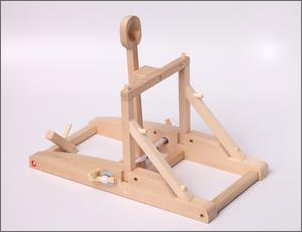

In [55]:
dataset[1]['image']

In [95]:
raw_images = [img for img in dataset[1:2]['image'] if img]
raw_images

[<PIL.PngImagePlugin.PngImageFile image mode=RGB size=302x232>]

In [96]:
X = processor(images=raw_images, return_tensors="pt")
X['pixel_values'].shape

torch.Size([1, 3, 800, 1041])

In [84]:
vision_model(**X).encoder_last_hidden_state.shape

torch.Size([5, 950, 256])

In [61]:
vision_model.device

device(type='cpu')